# Phase 1 - Ingestion and Cleaning

This notebook carries out the following steps
  1. Ingest data downloaded from the LendingClub website
  2. Prepare the data set
  3. Visualizes single variable summaries
  4. Removes outliers
  5. Output a dataset ready for later analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn
import numpy as np
import plotly.express as px


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

## Parameters

In [4]:
# Define the directories that contain the files downloaded most recently
# In the example below, I created a directory called 200711Data in the place containing this
#   script and put in there the zipped file downloaded from Lending Club titled
#  "2007-2011-LoanStats3a_securev1.csv.gz"
dir_data = "/content/drive/My Drive/BVIA Group 4/201213Data"
#dir_data = "/".join( ['..'] + ["201213Data"] )


# Define the output path for the pickle
pickle_dir = "/content/drive/My Drive/BVIA Group 4/Pickle/"
pickle_file = "/content/drive/My Drive/BVIA Group 4/Pickle/201213_w2.pickle" #change the name of the pickle file here 
#pickle_file = "/".join( ['.'] + ["PickleData"] + ["201213clean_data.pickle"] )

In [5]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick = ['id','loan_amnt','funded_amnt','term','int_rate',
                 'installment','grade','emp_length', 'home_ownership',
                 'annual_inc','verification_status','issue_d',
                 'loan_status','purpose','dti', 'delinq_2yrs',
                 'earliest_cr_line','open_acc','pub_rec', 'fico_range_high',
                 'fico_range_low', 'revol_bal','revol_util', 'total_pymnt',
                                                    'last_pymnt_d', 'recoveries']

# Identify the type of each of these column
float_cols = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
                     'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
                                'fico_range_high', 'fico_range_low', 'total_pymnt', 'recoveries']
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership',
                    'verification_status', 'loan_status', 'purpose']
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [6]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features
discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

## Step 1 - Ingestion
Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

In [7]:
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    Lending Club, and *only* those files. Thus, we assume the files are zipped
    (pd.read_csv can read zipped files) and we assume the first line
    in each file needs to be skipped. 
    
    Note that this function will read and ingest more than one file and is
    convenient if you want to ingest data for more than one year at a time.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory = directory + "/"
    
    all_files = os.listdir(directory)
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory + i, dtype = str, skiprows = 1)
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = (output[i].id.apply( lambda x : is_integer(x) == False ))
        if invalid_rows.sum() > 0:
            print("        Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i][invalid_rows == False]
    
    return output

In [8]:
# Ingest the set of files we downloaded 
files_data = ingest_files(dir_data)

Directory /content/drive/My Drive/BVIA Group 4/201213Data/ has 1 files:
    Reading file LoanStats3b_securev1.csv.zip
        Found 2 invalid rows which were removed


In [9]:
data_now = pd.concat(files_data.values()).reset_index(drop = True)
columns = list(data_now.columns)

In [10]:
data_now.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
count,188181,0,188181,188181,188181,188181,188181,188181,188181,188181,176444,180294,188181,188181,188181,188181,188181,188181,188181,81478,188181,188174,188181,188181,188181,188181,188181,188181,188181,188181,80608,17474,188181,188181,188181,188056,188181,188181,188181,188181,...,188181,160440,180686,180686,160440,0,0,0,0,0,0,0,0,0,0,0,0,0,188181,71,80,80,80,80,80,80,77,80,80,80,72,80,80,188181,2093,2093,2093,2093,2093,2093
unique,188181,0,1258,1259,1694,2,145,29666,7,35,115187,11,5,15610,3,24,2,1,188181,80660,13,44971,839,49,3499,20,614,38,38,9,130,120,54,14,43591,1068,88,2,1,1,...,13,115320,81325,10903,66962,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,11,3,1,72,10,11,12,1,23,7,64,72,79,2,86,3,88,1815,636,26
top,8607600,NaN,10000,10000,10000,36 months,12.12%,332.72,B,B3,Teacher,10+ years,MORTGAGE,60000,Verified,Dec-2013,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 01/14/13 > Debt consolidat...,debt_consolidation,Debt consolidation,945xx,CA,14.4,0,Oct-2000,680,684,0,8,98,9,0,0,0%,22,f,0.00,0.00,...,0,13700,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,INTEREST ONLY-3 MONTHS DEFERRAL,NATURAL_DISASTER,COMPLETED,3,0,Sep-2017,Dec-2017,Oct-2017,3,0,Late (16-30 days),0,0,0.13,N,Jul-2015,COMPLETE,Jan-2015,5000,45,0
freq,1,NaN,13744,13743,12048,143892,9409,823,62623,15618,833,61199,97012,7207,87389,15020,158510,188181,1,6,111451,23110,2327,30743,202,158451,1646,15240,15240,95857,1693,525,18670,170707,603,624,7187,148364,188181,188181,...,186530,74,79,1533,26983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,188181,71,24,63,80,9,26,21,22,80,20,29,9,9,2,186088,74,1773,125,13,408,1133


## Step 2 - Prepare Dataset

In [11]:
# Keep only the columns of interest
final_data = data_now[cols_to_pick].copy()

In [12]:
print("Starting with " + str(len(final_data)) + " rows")

Starting with 188181 rows


### Typecast the columns

In [13]:
for i in float_cols:
    final_data[i] = final_data[i].astype(float)
    
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])
for i in perc_cols:
    final_data[i] = final_data[i].apply( clean_perc )
    
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()
for i in date_cols:
    final_data[i] = final_data[i].apply( clean_date )
    
for i in cat_cols:
    final_data.loc[final_data[i].isnull(), i] = None

In [14]:
# Retain original version of untransformed variables
final_data_orig = final_data.copy()
final_data_orig.columns = ["id"] + [c+"_orig" for c in final_data_orig.columns if c != "id"]
final_data = pd.merge(final_data, final_data_orig, left_on="id",right_on="id")

## Step 3- Visualize the variables

In [15]:
def visualize_columns():
    '''
    This function visualizes all columns
      - Box-and-whisker and histogram plots for continuous variables
      - Lists of distinct values for categorical columns
      - A timeline density for dates
    '''
    
    # Float columns
    for i in float_cols + perc_cols:
        fig, axs = plt.subplots(1, 2, tight_layout=True)

        seaborn.boxplot(final_data[i], ax = axs[0])

        # Print the three highest values
        highest_vals = sorted(final_data[i], reverse=True)[:3]
        smallest_val = round(min(final_data[i]),2)
        axs[0].text(smallest_val, -0.3, round(highest_vals[0],2))
        axs[0].text(smallest_val, -0.2, round(highest_vals[1],2))
        axs[0].text(smallest_val, -0.1, round(highest_vals[2],2))

        #Draw the histogram
        axs[1] = plt.hist(final_data[i],50)
        plt.show()
        
    # Categorical columns 
    for i in cat_cols:
        print(i)
        print(str(len(set(final_data[i]))) + " distinct values")
        print(final_data[i].value_counts())
        print("")
        print("")
    
    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

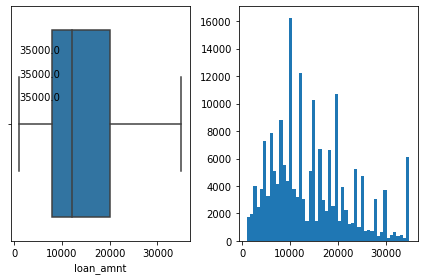

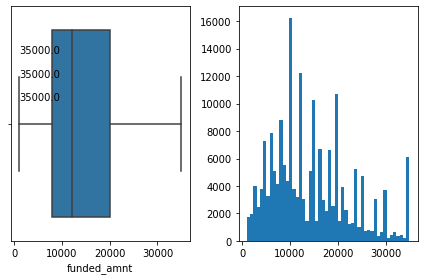

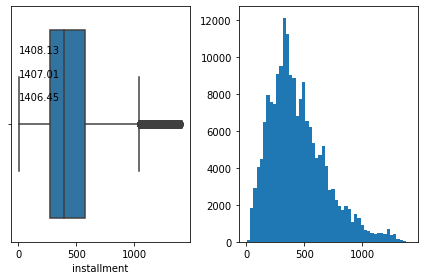

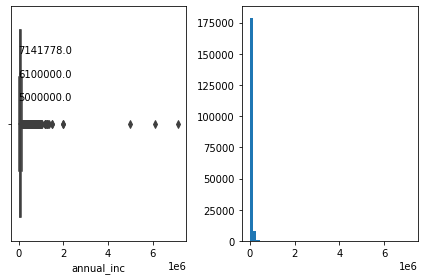

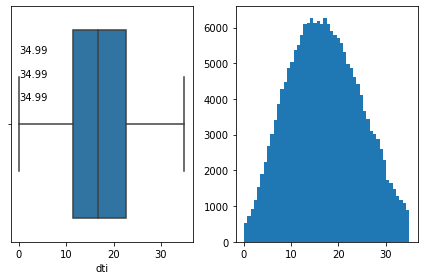

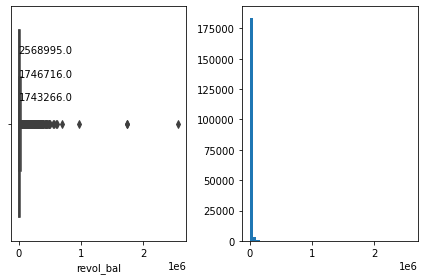

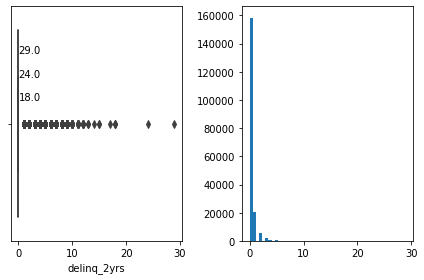

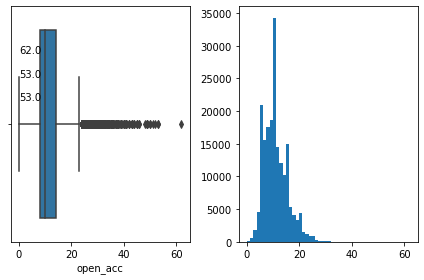

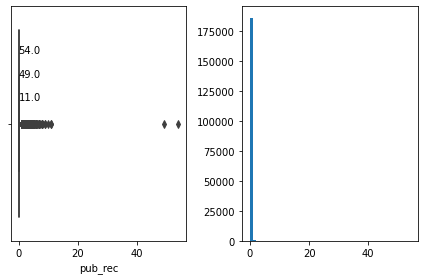

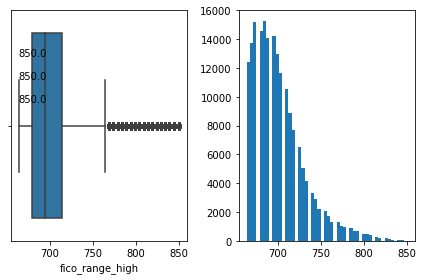

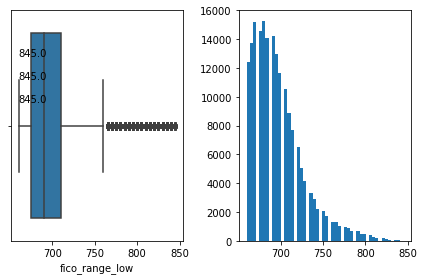

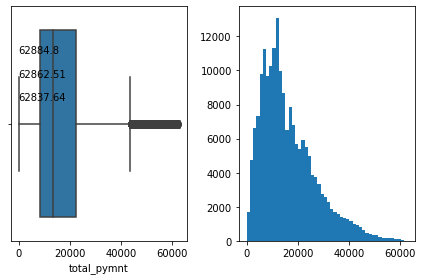

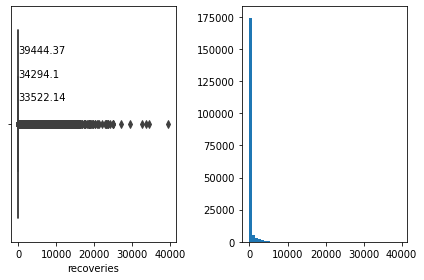

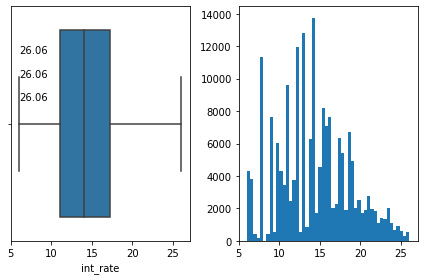

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning:

invalid value encountered in greater_equal

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning:

invalid value encountered in less_equal



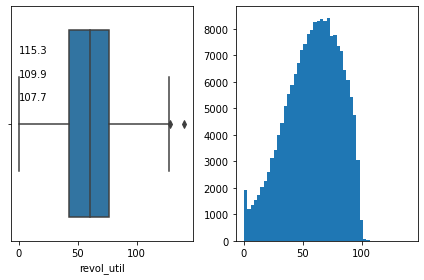

term
2 distinct values
 36 months    143892
 60 months     44289
Name: term, dtype: int64


grade
7 distinct values
B    62623
C    50009
A    28580
D    27892
E    12244
F     5708
G     1125
Name: grade, dtype: int64


emp_length
12 distinct values
10+ years    61199
2 years      16146
5 years      14270
3 years      13967
< 1 year     13224
6 years      11918
1 year       11434
7 years      11211
4 years      10847
8 years       8952
9 years       7126
Name: emp_length, dtype: int64


home_ownership
5 distinct values
MORTGAGE    97012
RENT        75627
OWN         15454
OTHER          46
NONE           42
Name: home_ownership, dtype: int64


verification_status
3 distinct values
Verified           87389
Not Verified       58828
Source Verified    41964
Name: verification_status, dtype: int64


loan_status
2 distinct values
Fully Paid     158510
Charged Off     29671
Name: loan_status, dtype: int64


purpose
13 distinct values
debt_consolidation    111451
credit_card            43170

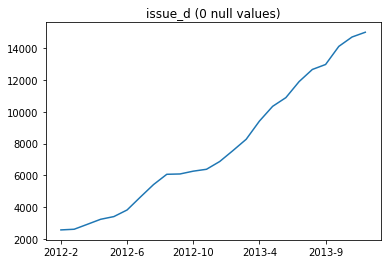

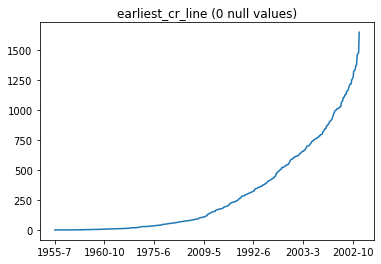

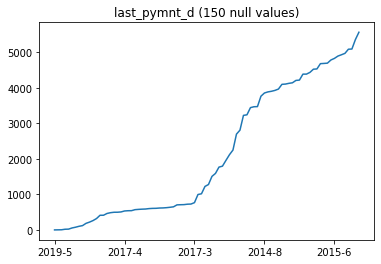

In [16]:
visualize_columns()

## Step 4 - Handle outliers

In [17]:
# There are quite a few outliers, but the two most obvious
# ones to remove are in annual_inc, revol_bal Remove these.
n_rows = len(final_data)
final_data = final_data[final_data.annual_inc < 1000000]
final_data = final_data[final_data.revol_bal < 400000]
final_data = final_data[final_data.dti < 200]
final_data = final_data[final_data.pub_rec < 50] #newly added <---
final_data = final_data[final_data.revol_util < 110] #newly added <---

#Remove all numerical columns having value less than zero. This will help in successful log transformation

for col in float_cols + perc_cols:
  final_data.drop(final_data[final_data[col] < 0].index, inplace = True)

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 180 rows


In [18]:
final_data.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,open_acc,pub_rec,fico_range_high,fico_range_low,revol_bal,revol_util,total_pymnt,last_pymnt_d,recoveries,loan_amnt_orig,funded_amnt_orig,term_orig,int_rate_orig,installment_orig,grade_orig,emp_length_orig,home_ownership_orig,annual_inc_orig,verification_status_orig,issue_d_orig,loan_status_orig,purpose_orig,dti_orig,delinq_2yrs_orig,earliest_cr_line_orig,open_acc_orig,pub_rec_orig,fico_range_high_orig,fico_range_low_orig,revol_bal_orig,revol_util_orig,total_pymnt_orig,last_pymnt_d_orig,recoveries_orig
0,10148122,12000.0,12000.0,36 months,7.62,373.94,A,3 years,MORTGAGE,96500.0,Not Verified,2013-12-01,Fully Paid,debt_consolidation,12.61,0.0,2003-09-01,17.0,0.0,709.0,705.0,13248.0,55.7,13397.539998,2016-06-01,0.0,12000.0,12000.0,36 months,7.62,373.94,A,3 years,MORTGAGE,96500.0,Not Verified,2013-12-01,Fully Paid,debt_consolidation,12.61,0.0,2003-09-01,17.0,0.0,709.0,705.0,13248.0,55.7,13397.539998,2016-06-01,0.0
1,10149342,27050.0,27050.0,36 months,10.99,885.46,B,10+ years,OWN,55000.0,Verified,2013-12-01,Fully Paid,debt_consolidation,22.87,0.0,1986-10-01,14.0,0.0,734.0,730.0,36638.0,61.2,31752.530000,2016-07-01,0.0,27050.0,27050.0,36 months,10.99,885.46,B,10+ years,OWN,55000.0,Verified,2013-12-01,Fully Paid,debt_consolidation,22.87,0.0,1986-10-01,14.0,0.0,734.0,730.0,36638.0,61.2,31752.530000,2016-07-01,0.0
2,10129454,12000.0,12000.0,36 months,10.99,392.81,B,4 years,RENT,60000.0,Not Verified,2013-12-01,Fully Paid,debt_consolidation,4.62,0.0,2009-12-01,15.0,0.0,724.0,720.0,7137.0,24.0,13988.609996,2016-04-01,0.0,12000.0,12000.0,36 months,10.99,392.81,B,4 years,RENT,60000.0,Not Verified,2013-12-01,Fully Paid,debt_consolidation,4.62,0.0,2009-12-01,15.0,0.0,724.0,720.0,7137.0,24.0,13988.609996,2016-04-01,0.0
3,10149488,4800.0,4800.0,36 months,10.99,157.13,B,2 years,MORTGAGE,39600.0,Source Verified,2013-12-01,Fully Paid,home_improvement,2.49,0.0,1995-08-01,3.0,0.0,759.0,755.0,4136.0,16.1,5157.519457,2014-09-01,0.0,4800.0,4800.0,36 months,10.99,157.13,B,2 years,MORTGAGE,39600.0,Source Verified,2013-12-01,Fully Paid,home_improvement,2.49,0.0,1995-08-01,3.0,0.0,759.0,755.0,4136.0,16.1,5157.519457,2014-09-01,0.0
4,10129477,14000.0,14000.0,36 months,12.85,470.71,B,4 years,RENT,88000.0,Not Verified,2013-12-01,Fully Paid,debt_consolidation,10.02,1.0,1988-06-01,6.0,1.0,674.0,670.0,3686.0,81.9,16945.318783,2017-01-01,0.0,14000.0,14000.0,36 months,12.85,470.71,B,4 years,RENT,88000.0,Not Verified,2013-12-01,Fully Paid,debt_consolidation,10.02,1.0,1988-06-01,6.0,1.0,674.0,670.0,3686.0,81.9,16945.318783,2017-01-01,0.0


In [19]:
# Remove all loans that are too recent to have been paid off or
# defaulted
n_rows = len(final_data)
final_data = final_data[final_data.loan_status.isin(['Fully Paid','Charged Off','Default'])]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 0 rows


In [20]:
# Only include loans issued since 2009
n_rows = len(final_data)
final_data = final_data[final_data.issue_d >= datetime.date(2009, 1, 1)]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 0 rows


In [21]:
## NOTE - NOT log transforming in this file. Log transforming later in the file.

# #log_transforms = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc', 'revol_bal', 'total_pymnt', 'recoveries']
# #scaled_transform = ['dti', 'delinq_2yrs', 'open_acc', 'pub_rec', 'fico_range_high', 'fico_range_low', 'int_rate', 'revol_util']

# #log transform 
# #to_log = float_cols + perc_cols
# #final_data1 = final_data[to_log].applymap(lambda x: np.log(x+1))

# for col in float_cols + perc_cols:
#   final_data[col] = np.log(final_data[col] + 1)
#   #df.apply(np.sqrt)


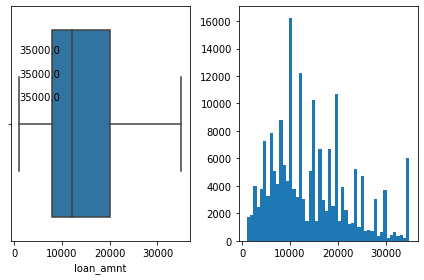

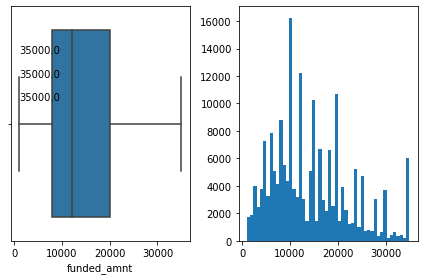

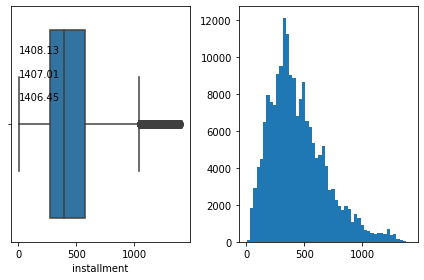

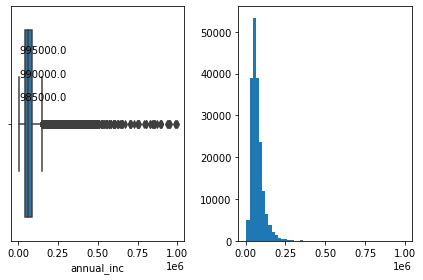

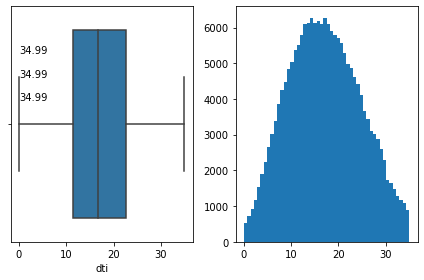

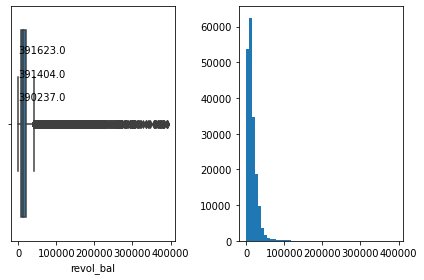

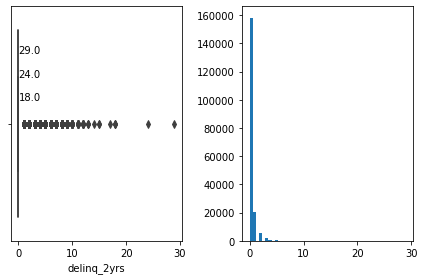

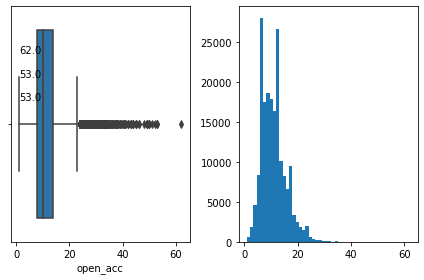

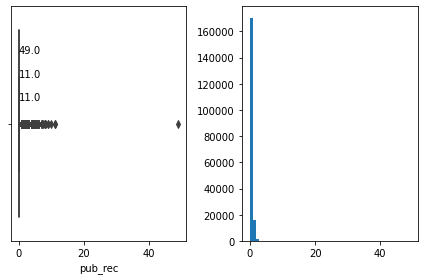

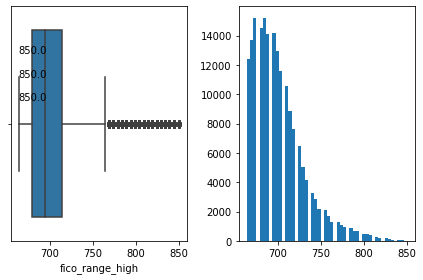

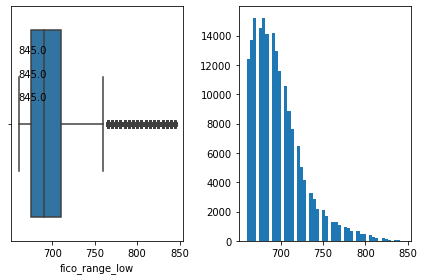

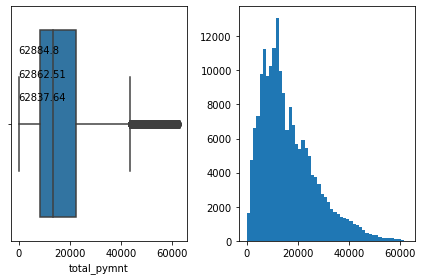

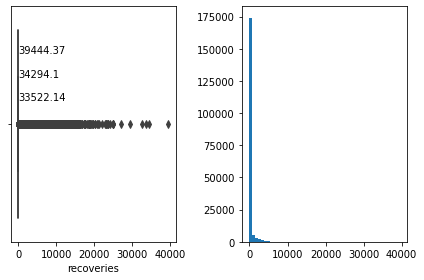

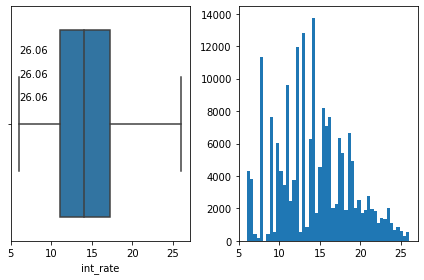

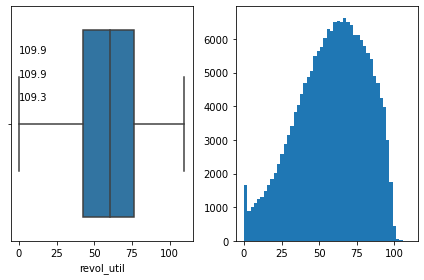

term
2 distinct values
 36 months    143749
 60 months     44252
Name: term, dtype: int64


grade
7 distinct values
B    62583
C    49969
A    28562
D    27848
E    12221
F     5699
G     1119
Name: grade, dtype: int64


emp_length
12 distinct values
10+ years    61129
2 years      16138
5 years      14256
3 years      13954
< 1 year     13208
6 years      11907
1 year       11421
7 years      11199
4 years      10838
8 years       8947
9 years       7120
Name: emp_length, dtype: int64


home_ownership
5 distinct values
MORTGAGE    96901
RENT        75572
OWN         15440
OTHER          46
NONE           42
Name: home_ownership, dtype: int64


verification_status
3 distinct values
Verified           87297
Not Verified       58798
Source Verified    41906
Name: verification_status, dtype: int64


loan_status
2 distinct values
Fully Paid     158358
Charged Off     29643
Name: loan_status, dtype: int64


purpose
13 distinct values
debt_consolidation    111370
credit_card            43145

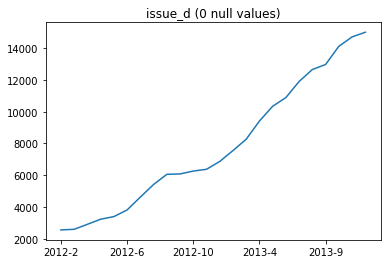

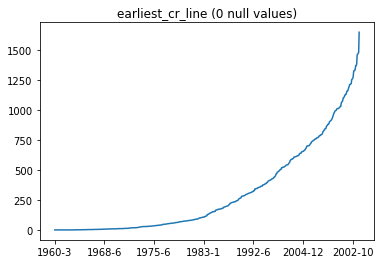

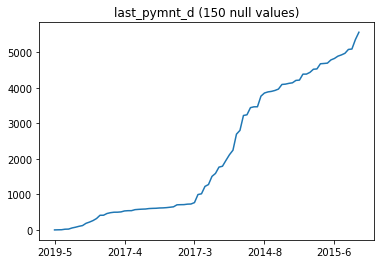

In [22]:
# Visualize the data again
visualize_columns()

### Drop null values

In [23]:
# Deal with null values. We allow categorical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)
final_data.dropna(subset = required_cols ,inplace=True)
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 150 rows


# Additional Cleaning

#### Removing more outliers

In [24]:
final_data = final_data[final_data.dti < 50]
final_data = final_data[final_data.revol_util < 110]

#### Log Transformation for left skewed columns

In [25]:
Log_Columns = ['annual_inc','revol_bal','open_acc', 'total_pymnt']

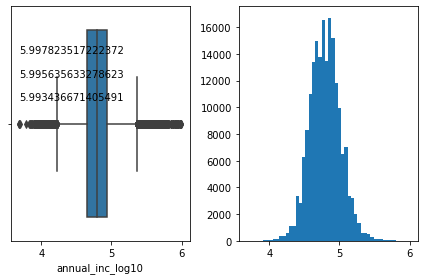

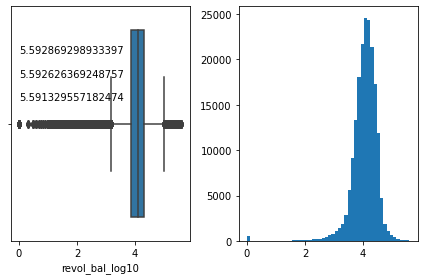

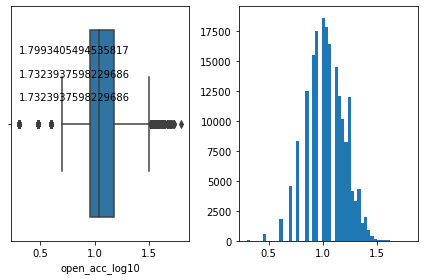

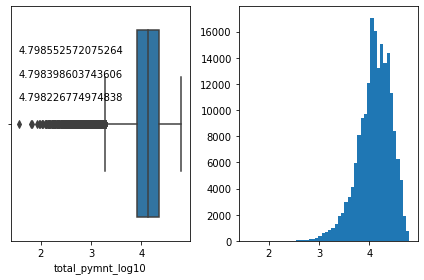

In [26]:
# Log Transform and plot box-plot and histogram
# Show original and transformed side by side
for i in Log_Columns:
    
    final_data[i+"_log10"] = np.log10(final_data[i]+1)
    
    fig, axs = plt.subplots(1, 2, tight_layout=True)

    seaborn.boxplot(final_data[i+"_log10"], ax = axs[0])

    # Print the three highest values
    highest_vals = sorted(final_data[i+"_log10"], reverse=True)[:3]
    smallest_val = min(final_data[i+"_log10"])
    axs[0].text(smallest_val, -0.3, highest_vals[0])
    axs[0].text(smallest_val, -0.2, highest_vals[1])
    axs[0].text(smallest_val, -0.1, highest_vals[2])

    #Draw the histogram
    axs[1] = plt.hist(final_data[i+"_log10"],50)

In [27]:
# Replace chosen columns with log version
for col in Log_Columns:
  final_data[col] = final_data[col+"_log10"]

In [28]:
final_data.drop(columns=[c+"_log10" for c in Log_Columns],inplace=True)

## Step 5 - Save a Pickle

In [29]:
# Remove the total_pymnt from the list of continuous features; this
# variable is highly predictive of the outcome but is not known at
# the time the loan is issued
continuous_features = [i for i in continuous_features if i not in ["total_pymnt", "recoveries"]]

In [30]:
final_data.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,open_acc,pub_rec,fico_range_high,fico_range_low,revol_bal,revol_util,total_pymnt,last_pymnt_d,recoveries,loan_amnt_orig,funded_amnt_orig,term_orig,int_rate_orig,installment_orig,grade_orig,emp_length_orig,home_ownership_orig,annual_inc_orig,verification_status_orig,issue_d_orig,loan_status_orig,purpose_orig,dti_orig,delinq_2yrs_orig,earliest_cr_line_orig,open_acc_orig,pub_rec_orig,fico_range_high_orig,fico_range_low_orig,revol_bal_orig,revol_util_orig,total_pymnt_orig,last_pymnt_d_orig,recoveries_orig
0,10148122,12000.0,12000.0,36 months,7.62,373.94,A,3 years,MORTGAGE,4.984532,Not Verified,2013-12-01,Fully Paid,debt_consolidation,12.61,0.0,2003-09-01,1.255273,0.0,709.0,705.0,4.122183,55.7,4.127057,2016-06-01,0.0,12000.0,12000.0,36 months,7.62,373.94,A,3 years,MORTGAGE,96500.0,Not Verified,2013-12-01,Fully Paid,debt_consolidation,12.61,0.0,2003-09-01,17.0,0.0,709.0,705.0,13248.0,55.7,13397.539998,2016-06-01,0.0
1,10149342,27050.0,27050.0,36 months,10.99,885.46,B,10+ years,OWN,4.740371,Verified,2013-12-01,Fully Paid,debt_consolidation,22.87,0.0,1986-10-01,1.176091,0.0,734.0,730.0,4.563944,61.2,4.501792,2016-07-01,0.0,27050.0,27050.0,36 months,10.99,885.46,B,10+ years,OWN,55000.0,Verified,2013-12-01,Fully Paid,debt_consolidation,22.87,0.0,1986-10-01,14.0,0.0,734.0,730.0,36638.0,61.2,31752.530000,2016-07-01,0.0
2,10129454,12000.0,12000.0,36 months,10.99,392.81,B,4 years,RENT,4.778158,Not Verified,2013-12-01,Fully Paid,debt_consolidation,4.62,0.0,2009-12-01,1.204120,0.0,724.0,720.0,3.853577,24.0,4.145806,2016-04-01,0.0,12000.0,12000.0,36 months,10.99,392.81,B,4 years,RENT,60000.0,Not Verified,2013-12-01,Fully Paid,debt_consolidation,4.62,0.0,2009-12-01,15.0,0.0,724.0,720.0,7137.0,24.0,13988.609996,2016-04-01,0.0
3,10149488,4800.0,4800.0,36 months,10.99,157.13,B,2 years,MORTGAGE,4.597706,Source Verified,2013-12-01,Fully Paid,home_improvement,2.49,0.0,1995-08-01,0.602060,0.0,759.0,755.0,3.616686,16.1,3.712525,2014-09-01,0.0,4800.0,4800.0,36 months,10.99,157.13,B,2 years,MORTGAGE,39600.0,Source Verified,2013-12-01,Fully Paid,home_improvement,2.49,0.0,1995-08-01,3.0,0.0,759.0,755.0,4136.0,16.1,5157.519457,2014-09-01,0.0
4,10129477,14000.0,14000.0,36 months,12.85,470.71,B,4 years,RENT,4.944488,Not Verified,2013-12-01,Fully Paid,debt_consolidation,10.02,1.0,1988-06-01,0.845098,1.0,674.0,670.0,3.566673,81.9,4.229075,2017-01-01,0.0,14000.0,14000.0,36 months,12.85,470.71,B,4 years,RENT,88000.0,Not Verified,2013-12-01,Fully Paid,debt_consolidation,10.02,1.0,1988-06-01,6.0,1.0,674.0,670.0,3686.0,81.9,16945.318783,2017-01-01,0.0


In [31]:
pickle.dump([final_data, discrete_features, continuous_features], open(pickle_file, "wb") )

## Read from Pickle if Saved
Read data from saved pickle files 

In [32]:
### Read the data and features from the pickle
final_data, discrete_features, continuous_features = pickle.load( open(pickle_file, "rb" ) )
#final_data, discrete_features, continuous_features = pickle.load( open( "./PickleData/201213clean_data.pickle", "rb" ) )

In [33]:
final_data.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,open_acc,pub_rec,fico_range_high,fico_range_low,revol_bal,revol_util,total_pymnt,last_pymnt_d,recoveries,loan_amnt_orig,funded_amnt_orig,term_orig,int_rate_orig,installment_orig,grade_orig,emp_length_orig,home_ownership_orig,annual_inc_orig,verification_status_orig,issue_d_orig,loan_status_orig,purpose_orig,dti_orig,delinq_2yrs_orig,earliest_cr_line_orig,open_acc_orig,pub_rec_orig,fico_range_high_orig,fico_range_low_orig,revol_bal_orig,revol_util_orig,total_pymnt_orig,last_pymnt_d_orig,recoveries_orig
0,10148122,12000.0,12000.0,36 months,7.62,373.94,A,3 years,MORTGAGE,4.984532,Not Verified,2013-12-01,Fully Paid,debt_consolidation,12.61,0.0,2003-09-01,1.255273,0.0,709.0,705.0,4.122183,55.7,4.127057,2016-06-01,0.0,12000.0,12000.0,36 months,7.62,373.94,A,3 years,MORTGAGE,96500.0,Not Verified,2013-12-01,Fully Paid,debt_consolidation,12.61,0.0,2003-09-01,17.0,0.0,709.0,705.0,13248.0,55.7,13397.539998,2016-06-01,0.0
1,10149342,27050.0,27050.0,36 months,10.99,885.46,B,10+ years,OWN,4.740371,Verified,2013-12-01,Fully Paid,debt_consolidation,22.87,0.0,1986-10-01,1.176091,0.0,734.0,730.0,4.563944,61.2,4.501792,2016-07-01,0.0,27050.0,27050.0,36 months,10.99,885.46,B,10+ years,OWN,55000.0,Verified,2013-12-01,Fully Paid,debt_consolidation,22.87,0.0,1986-10-01,14.0,0.0,734.0,730.0,36638.0,61.2,31752.530000,2016-07-01,0.0
2,10129454,12000.0,12000.0,36 months,10.99,392.81,B,4 years,RENT,4.778158,Not Verified,2013-12-01,Fully Paid,debt_consolidation,4.62,0.0,2009-12-01,1.204120,0.0,724.0,720.0,3.853577,24.0,4.145806,2016-04-01,0.0,12000.0,12000.0,36 months,10.99,392.81,B,4 years,RENT,60000.0,Not Verified,2013-12-01,Fully Paid,debt_consolidation,4.62,0.0,2009-12-01,15.0,0.0,724.0,720.0,7137.0,24.0,13988.609996,2016-04-01,0.0
3,10149488,4800.0,4800.0,36 months,10.99,157.13,B,2 years,MORTGAGE,4.597706,Source Verified,2013-12-01,Fully Paid,home_improvement,2.49,0.0,1995-08-01,0.602060,0.0,759.0,755.0,3.616686,16.1,3.712525,2014-09-01,0.0,4800.0,4800.0,36 months,10.99,157.13,B,2 years,MORTGAGE,39600.0,Source Verified,2013-12-01,Fully Paid,home_improvement,2.49,0.0,1995-08-01,3.0,0.0,759.0,755.0,4136.0,16.1,5157.519457,2014-09-01,0.0
4,10129477,14000.0,14000.0,36 months,12.85,470.71,B,4 years,RENT,4.944488,Not Verified,2013-12-01,Fully Paid,debt_consolidation,10.02,1.0,1988-06-01,0.845098,1.0,674.0,670.0,3.566673,81.9,4.229075,2017-01-01,0.0,14000.0,14000.0,36 months,12.85,470.71,B,4 years,RENT,88000.0,Not Verified,2013-12-01,Fully Paid,debt_consolidation,10.02,1.0,1988-06-01,6.0,1.0,674.0,670.0,3686.0,81.9,16945.318783,2017-01-01,0.0


In [34]:
#final_data.to_csv("200711clean_data.csv")